<a href="https://colab.research.google.com/github/ambideXtrous9/Dog_Breed_Classification-StanfordDogsDataset-/blob/main/StanfordDogs_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import tensorflow_datasets as tfds
import tensorflow as tf
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,InceptionV3,VGG16,MobileNetV3Large
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
import tarfile
import pandas as pd
from google.colab.patches import cv2_imshow
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [2]:
_URL = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'

In [3]:
zip_dir = tf.keras.utils.get_file('/content/StanfordDogs', origin=_URL, untar=True,extract=True)

793583616/793579520 [==============================] - 8s 0us/step


In [4]:
fname = '/content/StanfordDogs.tar.gz'

In [5]:
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

In [6]:
testimg_path = '/content/Images/n02085620-Chihuahua/n02085620_10074.jpg'

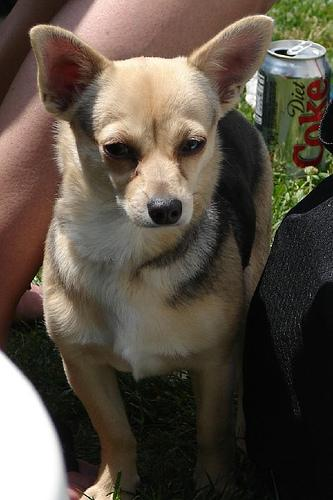

(500, 333, 3)

In [7]:
image = cv2.imread(testimg_path)
cv2_imshow(image)
image.shape

In [8]:
my_list = os.listdir('/content/Images')

In [9]:
my_list

['n02113799-standard_poodle',
 'n02102177-Welsh_springer_spaniel',
 'n02097130-giant_schnauzer',
 'n02108551-Tibetan_mastiff',
 'n02094433-Yorkshire_terrier',
 'n02087046-toy_terrier',
 'n02093428-American_Staffordshire_terrier',
 'n02107683-Bernese_mountain_dog',
 'n02095314-wire-haired_fox_terrier',
 'n02088364-beagle',
 'n02109525-Saint_Bernard',
 'n02099429-curly-coated_retriever',
 'n02106166-Border_collie',
 'n02116738-African_hunting_dog',
 'n02112706-Brabancon_griffon',
 'n02106030-collie',
 'n02097209-standard_schnauzer',
 'n02085782-Japanese_spaniel',
 'n02093256-Staffordshire_bullterrier',
 'n02112018-Pomeranian',
 'n02087394-Rhodesian_ridgeback',
 'n02089867-Walker_hound',
 'n02101388-Brittany_spaniel',
 'n02108089-boxer',
 'n02097298-Scotch_terrier',
 'n02115641-dingo',
 'n02107312-miniature_pinscher',
 'n02110806-basenji',
 'n02086240-Shih-Tzu',
 'n02085936-Maltese_dog',
 'n02089973-English_foxhound',
 'n02101006-Gordon_setter',
 'n02086079-Pekinese',
 'n02110185-Siberian

# Selecting first 25 dogs classes among 120.

In [10]:
class_names = ['n02113799-standard_poodle',
 'n02102177-Welsh_springer_spaniel',
 'n02097130-giant_schnauzer',
 'n02108551-Tibetan_mastiff',
 'n02094433-Yorkshire_terrier',
 'n02087046-toy_terrier',
 'n02093428-American_Staffordshire_terrier',
 'n02107683-Bernese_mountain_dog',
 'n02095314-wire-haired_fox_terrier',
 'n02088364-beagle',
 'n02109525-Saint_Bernard',
 'n02099429-curly-coated_retriever',
 'n02106166-Border_collie',
 'n02116738-African_hunting_dog',
 'n02112706-Brabancon_griffon',
 'n02106030-collie',
 'n02097209-standard_schnauzer',
 'n02085782-Japanese_spaniel',
 'n02093256-Staffordshire_bullterrier',
 'n02112018-Pomeranian',
 'n02087394-Rhodesian_ridgeback',
 'n02089867-Walker_hound',
 'n02101388-Brittany_spaniel',
 'n02108089-boxer',
 'n02097298-Scotch_terrier']

In [11]:
len(class_names)

25

In [12]:
IMG_SIZE = 224
INIT_LR = 1e-5
EPOCHS =  50
BS = 8

In [13]:
train = ImageDataGenerator(
rescale = 1/255,
horizontal_flip=True,
vertical_flip=True,
shear_range=0.2,
zoom_range=0.2,
featurewise_center=True, # Set input mean to 0 over the dataset, feature-wise
featurewise_std_normalization=True, # Divide inputs by std of the dataset, feature-wise
rotation_range=40, # Degree range for random rotations
width_shift_range=0.2,
height_shift_range=0.2,
fill_mode='nearest',
validation_split = 0.2)

In [14]:
dest = '/content/Images'

In [15]:
trainset = train.flow_from_directory(dest,
target_size = (IMG_SIZE,IMG_SIZE),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
subset = 'training',
classes=class_names, # if None-> all dog classes will be considered, if classes=class_names->only those classes will be considered
class_mode='categorical')

Found 3317 images belonging to 25 classes.


In [16]:
validset = train.flow_from_directory(dest,
target_size = (IMG_SIZE,IMG_SIZE),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
subset = 'validation',
classes=class_names,
class_mode='categorical')

Found 817 images belonging to 25 classes.


In [17]:
NAME_CLASSES = trainset.class_indices

In [18]:
NUM_CLASSES = len(NAME_CLASSES)

In [19]:
NUM_CLASSES

25

In [20]:
trainset.num_classes

25

In [25]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(IMG_SIZE,IMG_SIZE, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(trainset.num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
#sgd = SGD(lr=INIT_LR,momentum=0.9,nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer='sgd',metrics=["accuracy"])
# train the head of the network

9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...


In [26]:
H = model.fit_generator(
	trainset,
  validation_data = validset,
	epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
415/415 [==============================] - 70s 137ms/step - loss: 2.8969 - accuracy: 0.1917 - val_loss: 1.9889 - val_accuracy: 0.4308
Epoch 2/50
415/415 [==============================] - 56s 134ms/step - loss: 2.0741 - accuracy: 0.3853 - val_loss: 1.5974 - val_accuracy: 0.5312
Epoch 3/50
415/415 [==============================] - 55s 134ms/step - loss: 1.8514 - accuracy: 0.4540 - val_loss: 1.4498 - val_accuracy: 0.5569
Epoch 4/50
415/415 [==============================] - 55s 132ms/step - loss: 1.6675 - accuracy: 0.4980 - val_loss: 1.3508 - val_accuracy: 0.5667
Epoch 5/50
415/415 [==============================] - 57s 137ms/step - loss: 1.5845 - accuracy: 0.5173 - val_loss: 1.2875 - val_accuracy: 0.6132
Epoch 6/50
415/415 [==============================] - 55s 134ms/step - loss: 1.5352 - accuracy: 0.5231 - val_loss: 1.1863 - val_accuracy: 0.6157
Epoch 7/50
415/415 [==============================] - 55s 133ms/step - loss: 1.4480 - accuracy: 0.5635 - val_loss: 1.2469 - val_ac

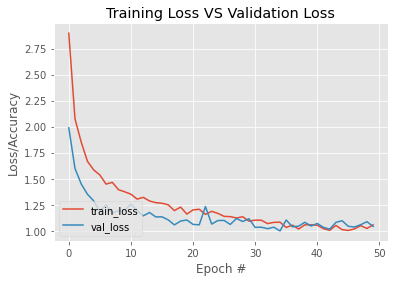

<Figure size 432x288 with 0 Axes>

In [27]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss VS Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('graph.png')

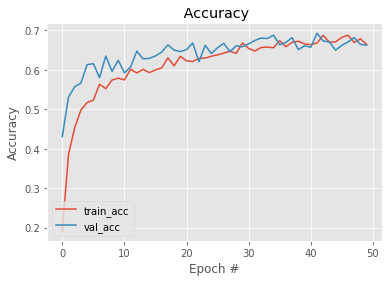

In [28]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title(" Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

In [29]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
validset.reset()
predIdxs = model.predict(x=validset)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(validset.classes, predIdxs,
	target_names=validset.class_indices.keys()))
# serialize the model to disk
print("[INFO] serializing network...")
model.save('StanfordDogs_MobileNetV2.model', save_format="h5")

[INFO] evaluating after fine-tuning network...


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


                                          precision    recall  f1-score   support

               n02113799-standard_poodle       0.63      0.61      0.62        31
        n02102177-Welsh_springer_spaniel       0.90      0.60      0.72        30
               n02097130-giant_schnauzer       0.69      0.35      0.47        31
               n02108551-Tibetan_mastiff       0.68      0.70      0.69        30
             n02094433-Yorkshire_terrier       0.93      0.81      0.87        32
                   n02087046-toy_terrier       0.67      0.53      0.59        34
n02093428-American_Staffordshire_terrier       0.64      0.22      0.33        32
          n02107683-Bernese_mountain_dog       0.74      0.86      0.80        43
       n02095314-wire-haired_fox_terrier       0.67      0.84      0.74        31
                        n02088364-beagle       0.51      0.67      0.58        39
                 n02109525-Saint_Bernard       0.54      0.85      0.66        34
        n020994

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Confusion Matrix


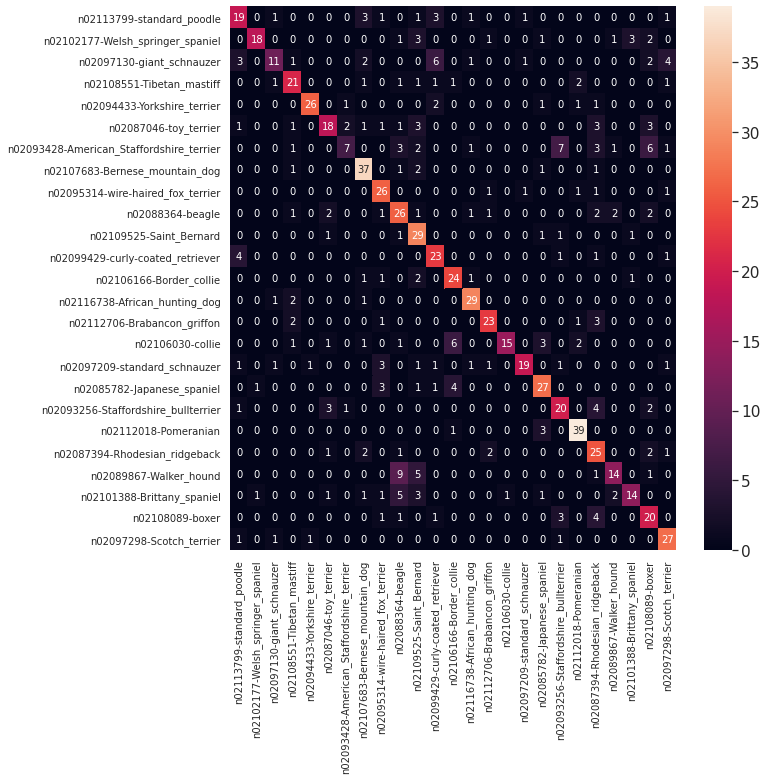

In [104]:
print('Confusion Matrix')
cm = confusion_matrix(validset.classes, predIdxs)
df_cm = pd.DataFrame(cm, range(25), range(25))
plt.figure(figsize=(10,10))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
ax.set_xticklabels(class_names, rotation='vertical', fontsize=10)
ax.set_yticklabels(class_names, rotation='horizontal', fontsize=10)
plt.show()

In [110]:
from PIL import Image,ImageDraw
def predimage(path,y):
    image = Image.open(path)
    test = load_img(path,target_size=(224,224))
    test = img_to_array(test)
    test = np.expand_dims(test,axis=0)
    test /= 255 
    result = model.predict(test,batch_size = BS)
    y_class = result.argmax(axis=-1)
    result = (result*100)
    result = list(np.around(np.array(result),2))
    i = y_class[0]
    s = result[0][i]
    plt.text(0, 0,y[y_class[0]],size=12,color='purple')
    plt.text(0, 50,s,size=15,color='red')
    plt.imshow(image)
    print(result)
    print(y[y_class[0]])

[array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.], dtype=float32)]
n02087046-toy_terrier


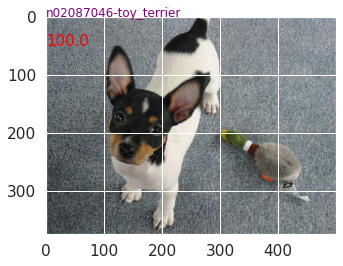

In [111]:
predimage('/content/Images/n02087046-toy_terrier/n02087046_1004.jpg',class_names)

[array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.], dtype=float32)]
n02087046-toy_terrier


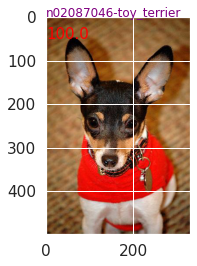

In [112]:
predimage('/content/Images/n02087046-toy_terrier/n02087046_1703.jpg',class_names)

[array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.], dtype=float32)]
n02085782-Japanese_spaniel


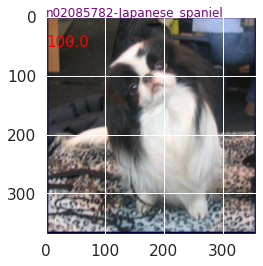

In [113]:
predimage('/content/Images/n02085782-Japanese_spaniel/n02085782_1460.jpg',class_names)

[array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.], dtype=float32)]
n02085782-Japanese_spaniel


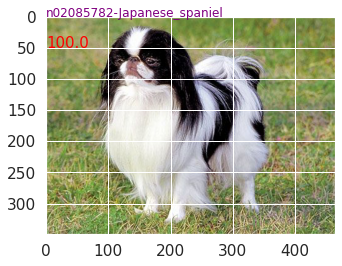

In [114]:
predimage('/content/jas.jpg',class_names)

[array([7.00e-02, 0.00e+00, 0.00e+00, 1.00e-02, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e-02,
       0.00e+00, 9.99e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00], dtype=float32)]
n02112018-Pomeranian


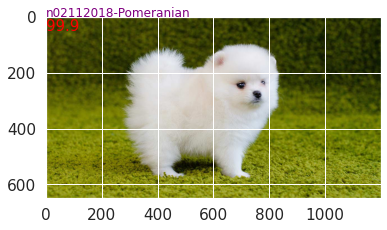

In [115]:
predimage('/content/pom.jpg',class_names)